## Imports

In [2]:
from tabulate import tabulate
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fractions import Fraction
from scipy.integrate import solve_ivp

## Define All Possible Events (test merge)


In [3]:
def sir_update(S, I, R, N, key):

    if key == 'infection':
        S -= 1
        I += 1
        return S, I, R, N
    elif key == 'recovery':
        R += 1
        I -= 1
        return S, I, R, N
    elif key == 'birth':
        S += 1
        N += 1
        return S, I, R, N
    elif key == 'death S':
        S -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death I':
        I -= 1
        N -= 1
        return S, I, R, N
    elif key == 'death R':
        R -= 1
        N -= 1
        return S, I, R, N




## Implement GSP 

- Add a way to control noise level (gsp function)
    - Larger N reduces noise
    - average results on multiple simulations
    - reduce noise after simultaion: remove high frequency fluctuations

In [4]:
    
def gsp(sir, beta, gamma, mu, end):
    """
    Simulates the disease spread using a Gillespie Stochastic Process (GSP) approach.

    Parameters:
        N (int): Total population size.
        X (int): Initial number of susceptible individuals.
        Y (int): Initial number of infected individuals.
        Z (int): Initial number of recovered individuals.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural death/birth rate.
        end (float): Time until the simulation ends.

    Returns:
        tuple: A list of time events and a list of population data over time.
    """
    S, I, R, N = sir
    t = 0
    
    t_events = []
    y_data = []
    
    while t <= end:
        
        # This queue collects the delta_t of each event at time t + delta_t
        event_queue = {}

        if S > 0 and I > 0 and N > 0:
            dt_infection = np.random.exponential(1/(beta*S*I/N))
            event_queue['infection'] = dt_infection

        if I > 0:
            dt_recovery = np.random.exponential(1/(gamma*I))
            event_queue['recovery'] = dt_recovery

        if N > 0:
            dt_birth = np.random.exponential(1/(mu*N))
            event_queue['birth'] = dt_birth

        if S > 0:
            dt_death_S = np.random.exponential(1/(mu*S))
            event_queue['death S'] = dt_death_S

        if I > 0:
            dt_death_I = np.random.exponential(1/(mu*I))
            event_queue['death I'] = dt_death_I

        if R > 0:
            dt_death_R = np.random.exponential(1/(mu*R))
            event_queue['death R'] = dt_death_R

        
        # Select the event with the smallest delta_t
        sorted_queue = dict(sorted(event_queue.items(), key=lambda item: item[1]))
        first_event_key, first_event_time = list(sorted_queue.items())[0]
        
        t += first_event_time
        t_events.append(t)

        # Handle each type of event
        S, I, R, N = sir_update(S, I, R, N, first_event_key)

        y_data.append([S, I, R])
    
    return (t_events, y_data)

            

        


## Run Stochastic Simulation

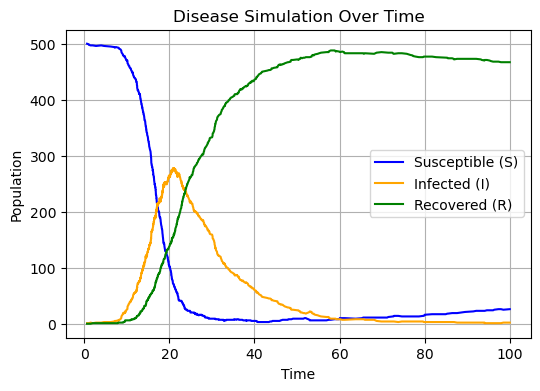

In [5]:
def run_simulation(sir, beta, gamma, mu, t_span):
    """
    Runs the disease simulation and plots the results.

    Parameters:
        N (int): Total population.
        X_0 (int): Initial susceptible population.
        Y_0 (int): Initial infected population.
        Z_0 (int): Initial recovered population.
        beta (float): Infection rate.
        gamma (float): Recovery rate.
        mu (float): Natural birth/death rate.
        t_span (int): Duration of the simulation.
    """

    
    t_events, y_data = gsp(sir, beta, gamma, mu, t_span)

    y_data = np.array(y_data)

    S = y_data[:, 0]
    I = y_data[:, 1]
    R = y_data[:, 2]

    plt.figure(figsize=(6, 4))
    plt.plot(t_events, S, label='Susceptible (S)', color='blue')
    plt.plot(t_events, I, label='Infected (I)', color='orange')
    plt.plot(t_events, R, label='Recovered (R)', color='green')

    plt.xlabel('Time')
    plt.ylabel('Population')
    plt.title('Disease Simulation Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()


# Parameters
N = 500
S = N - 1
I = N - S
R = 0

beta = 0.6
gamma = 0.1
mu = 0.001


t_span = 100

sir = [S, I, R, N]

run_simulation(sir, beta, gamma, mu, t_span)


## Run Deterministic Model

To do:

- Add similarity score between stochastic and derministic model.

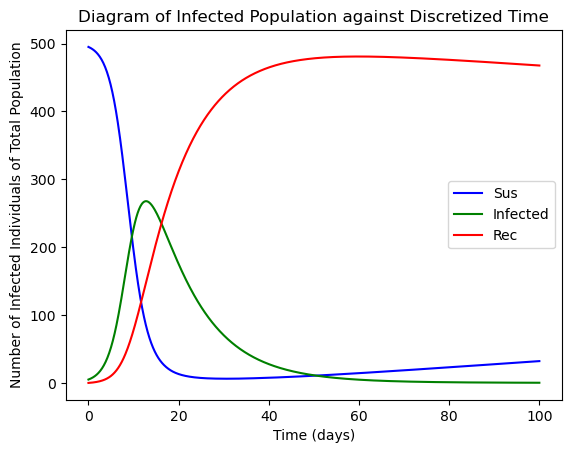

In [6]:
beta = 0.6
gamma = 0.1
mu = 0.001

parameters = [beta, gamma, mu]

t_span = 100

# Initial conditions with 99% susceptible, 1% infected and 0% recovered and a population of 100 people
S0 = 0.99
I0 = 0.01
R0 = 0
N = 500

# Creates a list of initial condition values
initial_conditions = [S0 * N, I0 * N, R0 * N]

# Calculates the ODEs and returns as a list
def calc_ode(t, sir, parameters, N):
    beta, gamma, mu = parameters
    sus, inf, rec = sir
    dSdt = mu*N - ((beta * sus * inf)/ N) - (mu * sus)
    dIdt = ((beta * sus * inf) / N) - (gamma * inf) - (mu * inf)
    dRdt = (gamma * inf) - (mu * rec)
    return [dSdt, dIdt, dRdt]

def plot_sir_ode(time, S, I, R):
    # Plots results
    plt.plot(time, S, label='Sus', color='b')
    plt.plot(time, I, label='Infected', color='g')
    plt.plot(time, R, label='Rec', color='r')
    plt.xlabel('Time (days)')
    plt.ylabel('Number of Infected Individuals of Total Population')
    plt.legend()
    plt.title('Diagram of Infected Population against Discretized Time')
    plt.show()

def run_sir_ode(sir, N, parameters, t_span):
    # Creates an array for each time measurement with 1600 samples, equally spaced between 0 and 1000
    time = np.linspace(0, t_span, 1000)

    # Solves for epidemic scenario with scipy.integrate function solove_ivp: 
    sir_integration = solve_ivp(calc_ode, [time[0], time[-1]], sir, args=(parameters, N), t_eval=time)

    # Assigns y values of sir_integration to correct labels, for later plotting
    S, I, R = sir_integration.y

    plot_sir_ode(time, S, I, R)

run_sir_ode(initial_conditions, N, parameters, t_span)

## Look at variance

- Plot results

- Delete print statements (not yet)

Beta/gamma pairs: [(0.312772807402493, 0.7510117977919898), (0.8459263131052888, 0.17280682562620575), (0.3519353882267603, 0.8264365814915507), (0.7772171036151706, 0.32054213226435896), (0.24914459050735838, 0.26330545259817717), (0.45825791927841686, 0.2754601488760029), (0.5606392770970038, 0.2739907057885203), (0.4160999805411397, 0.2828918498687364), (0.4979035758038943, 0.6831047657573255), (0.8195981003127122, 0.1622851560595846), (0.15146342043062502, 0.18272623136614297), (0.8555417997060337, 0.4385101731858737), (0.8762698772708047, 0.2813864038564128), (0.7046621846062687, 0.1660997562185048), (0.580916025901394, 0.41855295925581404), (0.8051417918394145, 0.24231952045276606), (0.6541046380936926, 0.7050866216123411), (0.30740717970500897, 0.321282521857439), (0.6443766705096554, 0.14365780997807473), (0.7833232320041067, 0.6731804265555661), (0.22224683854424612, 0.6118128637096351), (0.6651571203812549, 0.19117643733440515), (0.3299285907399739, 0.2858848325904694), (0.62

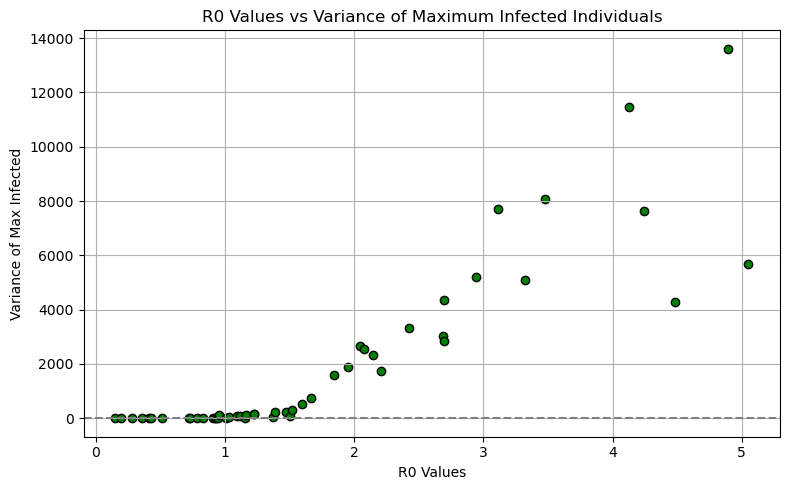

In [8]:
#np.random.seed(42)

def generate_parameters(num_samples, lower_ratio=0.45, upper_ratio=0.55, beta_range=(0.1, 0.9), gamma_range=(0.1, 0.9)):
    """
    Generates random beta and gamma pairs, calculates their R0 values, 
    and ensures the ratio of R0 values below and above 1 falls within specified bounds.
    
    Parameters:
        num_samples (int): Number of beta/gamma pairs to generate.
        lower_ratio (float): Lower bound for the ratio of R0 values below and above 1.
        upper_ratio (float): Upper bound for the ratio of R0 values below and above 1.
        beta_range (tuple): Range for beta values.
        gamma_range (tuple): Range for gamma values.
    
    Returns:
        list: List of (beta, gamma) pairs.
        list: List of R0 values.
        float: Ratio of R0 values below and above 1.
    """
    # Initialize ratio of R0 values smaller and larger than 1.
    ratio = 0

    #why?
    while ratio < lower_ratio or ratio > upper_ratio:

        betas = np.random.uniform(beta_range[0], beta_range[1], num_samples)
        gammas = np.random.uniform(gamma_range[0], gamma_range[1], num_samples)

        beta_gamma_pairs = list(zip(betas, gammas))
        R0_vals = [beta / gamma for beta, gamma in beta_gamma_pairs]

        # Calculate the ratio of R0 values < 1 and > 1
        num_below_one = np.sum(np.array(R0_vals) < 1)
        num_above_one = np.sum(np.array(R0_vals) > 1)
        ratio = num_below_one / (num_above_one + 1e-10)  # Avoid division by zero (this is hardcoding, another way?)

    R0_vals
    print("Beta/gamma pairs: " + str(beta_gamma_pairs))
    print("R0 values: " + str(R0_vals))
    print("Ratio: " + str(ratio))
    
    return beta_gamma_pairs, R0_vals




def parameter_sweep(sir, pairs, mu, num_runs):

    """
    Perform a parameter sweep over the SIR model simulation to analyze the impact of varying 
    beta and gamma values on the maximum number of infected individuals.

    Parameters:
    sir : function
        The SIR initial populations.
    pairs : list of tuples
        A list of (beta, gamma) tuples to be tested in the SIR model.
    mu : float
        The recovery rate parameter for the model.
    num_runs : int
        The number of times to run the simulation for each (beta, gamma) pair.

    Returns:
    list
        A list of variances of the maximum infected values for each (beta, gamma) pair.
    """
    
    variances = []

    for beta, gamma in pairs:
        
        max_I_vals = []
        
        # Run simulation n times for each (beta, gamma) pair.
        for _ in range(num_runs):

            result = gsp(sir, beta, gamma, mu, t_span)
            y_data = np.array(result[1])

            S = y_data[:, 0]
            I = y_data[:, 1]
            R = y_data[:, 2]

            # Extract max I value from each run.
            max_I_vals.append(np.max(I))
        
        print(f"Beta: {beta}, Gamma: {gamma}, Max Values: {max_I_vals}")
        # Variance for each (beta, gamma) pair after n runs is recorded.
        variances.append(np.var(max_I_vals))

    return variances




def plot_R0_vs_variance(R0_vals, variances):
    """
    Plots R0 values against the variances of maximum infected individuals.
    
    Parameters:
        R0_vals (list): List of R0 values.
        variances (list): List of variances corresponding to R0 values.
    """
    plt.figure(figsize=(8, 5))
    plt.scatter(R0_vals, variances, color='green', edgecolor='black')

    plt.xlabel('R0 Values')
    plt.ylabel('Variance of Max Infected')
    plt.title('R0 Values vs Variance of Maximum Infected Individuals')
    plt.axhline(0, color='gray', linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.grid(True)
    plt.tight_layout()
    plt.show()



# Define number of beta/gamma pairs.
num_pairs = 50

# Define number of runs per beta/gamma pair.
num_runs = 10

# Generate Parameters
sample_pairs, sample_R0_vals = generate_parameters(num_pairs)

# Calculate variances
variances = parameter_sweep(sir, sample_pairs, mu, num_runs)

# Combine and sort by R0
combined = list(zip(sample_R0_vals, variances))
sorted_combined = sorted(combined)
sorted_R0_vals, sorted_variances = zip(*sorted_combined)


plot_R0_vs_variance(sorted_R0_vals, sorted_variances)




## Calculate the Mean accross multiple runs 

In [7]:
def gsp_mean(runs, t_span):
    """"Runs the gsp 'runs' number of times to calculate the mean of each population at each time step. 
    Should we do mean for time or mean for steps? like step 1 does this in stead of mean for t = 0.0017 equals this
    To Do: figure out how to do the steps since different every run, how to make estimate?
        - linear interpolation, draw line between two points and take average (wont rly work well)"""
    
    # make a list of fixed time steps (we know t_end) if not until t_end, its the last value, 
    # if none at t_start it's first value
    
    t_steps = Fraction(t_span, 100)
    
    # end excluse end so include t_steps. steps are spacing between values
    fixed_steps = np.arange(0, t_span + t_steps, t_steps)



    for run in range(runs):
        # get data from run
        t_events , y_data = gsp(sir, beta, gamma, mu, t_span)

        # store data from run at those fixed time steps 
        results = {
            'time': [],
            'S': {},
            'I': {},
            'R': {},
            'N': {}}
        
        step = 0

        for index, time in enumerate(t_events):
            S, I, R in y_data[index]
            N = S + I + R

            results['time'].append(step)
            results['S'][time] = []
            results['I'][time] = []
            results['R'][t] = []
            results['N'][t] = []

            step += 1
            

       # Store data  next to existing data like [time event 1, S1, S2, S3 ... Sruns], [2, s1, s2 etc] Do it for all S, I, R (and N)
    return
        
# Parameters
N = 500
S = N - 1
I = N - S
R = 0

beta = 0.6
gamma = 0.1
mu = 0.001


t_span = 100

sir = [S, I, R, N]

run_simulation(sir, beta, gamma, mu, t_span)

SyntaxError: expected ':' (1388655163.py, line 12)